In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 8.7 MB/s 
     |████████████████████████████████| 182 kB 60.3 MB/s 
     |████████████████████████████████| 7.6 MB 31.0 MB/s 


In [2]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, TextDataset, DataCollatorForLanguageModeling, Trainer, TrainingArguments, AutoTokenizer, AutoModelWithLMHead


import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random

from tqdm.auto import tqdm

from nltk.translate.bleu_score import corpus_bleu, sentence_bleu

import re

In [3]:
!nvidia-smi

Wed Nov 23 03:49:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
data_file_open = open("data_f.txt", 'r', encoding='UTF-8')
label_file_open = open("label_f.txt", 'r', encoding='UTF-8')
data_lines=data_file_open.readlines()
label_lines = label_file_open.readlines()

input_dataset = []
output_dataset = []
dataset = []


for item in data_lines:
  input_dataset.append(item.strip())
for item in label_lines:
  output_dataset.append(item.strip())

In [10]:
tokenizer = AutoTokenizer.from_pretrained("t5-small")
model = AutoModelWithLMHead.from_pretrained("t5-small", pad_token_id=tokenizer.eos_token_id)

tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5_fast.py:166: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:1136: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language 

In [12]:
print(input_dataset[0])

Now, beautiful Hippolyta , the hour of our wedding is speeding closer.


In [14]:
for i in range(100):
    print(input_dataset[i])

Now, beautiful Hippolyta , the hour of our wedding is speeding closer.
Four days will quickly pass and turn to night.
And each night, we will dream away the time.
And soon the moon   like a silver bow newly bent into a curve in the sky  will look down on the night of our wedding celebration.
Go, Philostrate, get the young people of Athens in the mood to celebrate.
Wake up the lively and swift spirit of fun.
Joy to you, Theseus  our famous and distinguished duke!
Thank you, dear Egeus.
What’s going on with you?
I’ve come to you full of anger, to protest against the actions of my daughter, Hermia.
Step forward, Demetrius.
My noble lord Theseus, this man, Demetrius, has my blessing to marry her.
Step forward, Lysander.
Yet, my gracious duke, this man, Lysander, has put a spell on my daughter’s heart.
You, you, Lysander, you have given her poems, and exchanged tokens of love with my daughter.
And what do you say, Hermia?
So is Lysander.
Yes he is.
But in this situation, because he lacks yo

In [15]:
class ShakespeareDataset(Dataset):

    def __init__(self, encodings_data, encoding_label):
        self.encodings_data = encodings_data
        self.encoding_label = encoding_label
        
    def __getitem__(self, index):
        x = {key: torch.tensor(val[index]) for key,val in self.encodings_data.items()}
        y = {key: torch.tensor(val[index]) for key,val in self.encoding_label.items()}
        return_map={"x": x, "y": y}
        return return_map

    def __len__(self):
        return len(self.encodings_data['input_ids'])

In [16]:
train_dataset = ShakespeareDataset(tokenizer(input_dataset[:5000], truncation=True, padding=True), tokenizer(output_dataset[:5000], truncation=True, padding=True))
val_dataset = ShakespeareDataset(tokenizer(input_dataset[5000:5500], truncation=True, padding=True), tokenizer(output_dataset[5000:5500], truncation=True, padding=True))


In [17]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=False)

val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [20]:
tokenizer.decode(train_dataset[0]["y"]['input_ids'])

'Now, fair Hippolyta, our nuptial hour Draws on apace.</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>'

In [21]:
optimizer = AdamW(model.parameters(), lr=8e-5)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [23]:
model = model.to(device)

In [24]:
for batch in train_dataloader:
    print(batch["x"]['input_ids'])
    print(batch["y"]['input_ids'])
    break

tensor([[  852,     6,   786,   454, 23640,   120,    17,     9,     3,     6,
             8,  1781,    13,    69,  1683,    19,  1634,    53,  4645,     5,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1],
        [ 5933,   477,    56,  1224,  1903,    11,   919,    12,   706,     5,
             1,     1,     1,     1

In [25]:
train_loss_epochs = []
val_loss_epochs = []

In [26]:
epochs = 5

In [28]:

model = model.to(device)
for epoch in range(epochs):

    print("Epoch:",epoch+1)

    train_loss = 0
    
    model.train()
    for batch in tqdm(train_dataloader):
        
        input_ids = batch["x"]['input_ids'].to(device)
        attention_mask = batch["x"]['attention_mask'].to(device)
        ouput_ids = batch["y"]['input_ids'].to(device)

        #print(labels.shape)
        #print(batch)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=ouput_ids)
        #outputs = model(x['input_ids'],y['input_ids'])
        loss = outputs.loss

        train_loss += loss
        train_loss = train_loss.detach()

        loss.backward()

        optimizer.step()

        optimizer.zero_grad()

    print("Training Loss =",train_loss.cpu()/len(train_dataloader))

    train_loss_epochs.append(train_loss.cpu()/len(train_dataloader))



    val_loss = 0

    model.eval()
    for batch in tqdm(val_dataloader):

        input_ids = batch["x"]['input_ids'].to(device)
        attention_mask = batch["x"]['attention_mask'].to(device)
        ouput_ids = batch["y"]['input_ids'].to(device)

        #print(labels.shape)
        #print(batch)
        
        with torch.no_grad():
            #outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=ouput_ids)
            #outputs = model(x['input_ids'],y['input_ids'])
            val_loss += outputs.loss
        
    print("Validation Loss =",val_loss/len(val_dataloader))

    val_loss_epochs.append(val_loss.cpu()/len(val_dataloader))

Epoch: 1


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss = tensor(0.3110)


  0%|          | 0/63 [00:00<?, ?it/s]

Validation Loss = tensor(0.4016, device='cuda:0')
Epoch: 2


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss = tensor(0.2937)


  0%|          | 0/63 [00:00<?, ?it/s]

Validation Loss = tensor(0.3920, device='cuda:0')
Epoch: 3


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss = tensor(0.2808)


  0%|          | 0/63 [00:00<?, ?it/s]

Validation Loss = tensor(0.3871, device='cuda:0')
Epoch: 4


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss = tensor(0.2700)


  0%|          | 0/63 [00:00<?, ?it/s]

Validation Loss = tensor(0.3849, device='cuda:0')
Epoch: 5


  0%|          | 0/625 [00:00<?, ?it/s]

Training Loss = tensor(0.2604)


  0%|          | 0/63 [00:00<?, ?it/s]

Validation Loss = tensor(0.3828, device='cuda:0')


ValueError: ignored

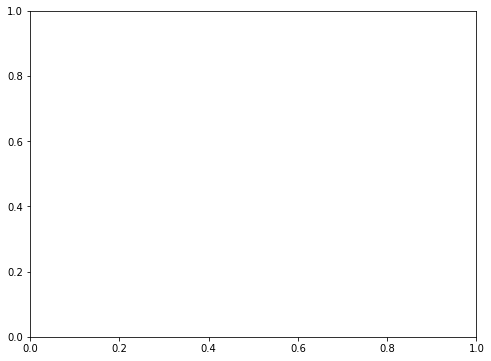

In [29]:
plt.figure(figsize=(8, 6))
plt.plot(torch.arange(epochs) , train_loss_epochs, label='Training Loss');
plt.plot(torch.arange(epochs) , val_loss_epochs, label='Validation Loss');
plt.xlabel('Epochs');
plt.ylabel('Loss');
plt.legend();

In [196]:
input_text="Please be gentle my lord, for the house is not stable now."
input = tokenizer.encode(input_text)

In [201]:
output = model.generate(input_ids=torch.tensor([input]).to(device), max_new_tokens=40, do_sample=True)
print(tokenizer.decode(output[0]))
print(input_text)

<pad> Do gentleness, my lord, as no stable building, for this.</s>
Please be gentle my lord, for the house is not stable now.


In [215]:
input_text="Good morning my lord, how is your day going?"
input = tokenizer.encode(input_text)
output = model.generate(input_ids=torch.tensor([input]).to(device), max_new_tokens=40, do_sample=True)
print(tokenizer.decode(output[0]))
print(input_text)

<pad> Good day my lord, how's thou day?</s>
Good morning my lord, how is your day going?


In [231]:
input_text="The task doesn't goes that well."
input = tokenizer.encode(input_text)
output = model.generate(input_ids=torch.tensor([input]).to(device), max_new_tokens=40, do_sample=True)
print(tokenizer.decode(output[0]))
print(input_text)

<pad> The task goes not so well.</s>
The task doesn't goes that well.


In [220]:
input = tokenizer.encode(input_dataset[3]+'=')
#input

#input = tokenizer.encode('Hello, how are you? = ')

In [221]:
def calculate_bleu(data):
    
    data = data.split('=')
    input = data[0]
    target = data[1].strip()
    input = tokenizer.encode(input+' =')
    output_final = []
    
    for i in range(len(target.split())+5):
        output = model(input_ids=torch.tensor([input]).to(device))
        input.append(torch.argmax(output.logits[0],dim=1)[-1].item())
        output_final.append(torch.argmax(output.logits[0],dim=1)[-1].item())
    
    decoded_output = tokenizer.decode(torch.tensor(input),skip_special_tokens=True)
    decoded_output = decoded_output.split('=')[1].strip()
    
    if(len(target.split())==1):
        weights = (1,)
    elif(len(target.split())==2):
        weights = (1,1)
    elif(len(target.split())==3 or len(target.split())==4):
        weights = (1,1,1)
    else:
        weights = (1,1,1,1)

    decoded_output = re.sub('[^ A-Za-z0-9]+', '', decoded_output)
    target = re.sub('[^ A-Za-z0-9]+', '', target)

    bleu = round(sentence_bleu([target.split()],decoded_output.split(),weights=weights),4)

    if bleu<1:
        print(len(target.split()))
        print(weights)
        print(target)
        print(decoded_output)
        print(bleu)

    return bleu

In [222]:
avg_bleu = 0
for i in range(1000,1100):
    avg_bleu += calculate_bleu(dataset[i])
avg_bleu = avg_bleu/100

print(avg_bleu)

ValueError: ignored

In [ ]:
ref = 'hello, how are you'
tar = 'hello how are you'

ref = re.sub('[^ A-Za-z0-9]+', '', ref)
print(ref)
bleu = round(sentence_bleu([ref.split()],tar.split(),weights=(1,1,1,1)),4)
print(bleu)

hello how are you
1.0


In [223]:
n = 2

data = dataset[n]

data = data.split('=')
input = data[0]
target = data[1].strip()
input = tokenizer.encode(input+' =')
output_final = []

for i in range(len(target.split())+5):
    output = model(input_ids=torch.tensor([input]).to(device))
    input.append(torch.argmax(output.logits[0],dim=1)[-1].item())
    output_final.append(torch.argmax(output.logits[0],dim=1)[-1].item())

decoded_output = tokenizer.decode(torch.tensor(input),skip_special_tokens=True)
decoded_output = decoded_output.split('=')[1].strip()

print(dataset[n])
print()
print(decoded_output)

ValueError: ignored

In [ ]:
input_new = input
output_final = []
for i in range(len(input)):
    output = model(input_ids=torch.tensor([input_new]).to(device))
    input_new.append(torch.argmax(output.logits[0],dim=1)[-1].item())
    output_final.append(torch.argmax(output.logits[0],dim=1)[-1].item())

In [ ]:
print()

In [ ]:
tokenizer.decode(torch.tensor(output_final))

'<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>'

In [ ]:
tokenizer.decode(torch.tensor(output_final))

'<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>'

In [ ]:
input 

[1870,
 2582,
 262,
 8824,
 588,
 257,
 8465,
 9563,
 8308,
 17157,
 656,
 257,
 12133,
 287,
 262,
 6766,
 481,
 804,
 866,
 319,
 262,
 1755,
 286,
 674,
 10614,
 14395,
 13,
 28,
 6675,
 12513,
 481,
 2952,
 14559,
 2405,
 287,
 1755,
 13,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256]

In [ ]:
output = model.generate(input_ids=torch.tensor([input]).to(device), do_sample=True, max_new_tokens=20)

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


In [ ]:
tokenizer.decode(output[0])

'And soon the moon like a silver bow newly bent into a curve in the sky will look down on the night of our wedding celebration.= Four nights will quickly steep themselves in night.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><

In [ ]:
torch.save(model.state_dict(), '/content/gpt2_training_2_100samples_overfit.pt')

In [ ]:
from google.colab import drive

import shutil

drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
shutil.copy("/content/gpt2_training_2_100samples_overfit.pt","/content/drive/MyDrive/ECE1786_Project/Models")

'/content/drive/MyDrive/ECE1786_Project/Models/gpt2_training_2_100samples_overfit.pt'